In [1]:
# Copyright 2020 MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
%matplotlib inline
import os
import sys
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import natsort
import torch
import torch.nn.functional as F
from monai.config import print_config
from monai.metrics import (
    get_confusion_matrix,
    compute_meandice,
    compute_confusion_matrix_metric
)
print_config()

MONAI version: 0.8.1
Numpy version: 1.22.3
Pytorch version: 1.10.2+cpu
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 71ff399a3ea07aef667b23653620a290364095b1

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 3.2.2
scikit-image version: NOT INSTALLED or UNKNOWN VERSION.
Pillow version: 9.0.1
Tensorboard version: NOT INSTALLED or UNKNOWN VERSION.
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.11.3+cpu
tqdm version: 4.63.0
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: NOT INSTALLED or UNKNOWN VERSION.
pandas version: NOT INSTALLED or UNKNOWN VERSION.
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [2]:
root_dir = "C:/Users/Karolinah/Documents/AICourse/testSet"
print(root_dir)

C:/Users/Karolinah/Documents/AICourse/testSet


In [3]:
cnfmx = None
dice = torch.zeros(4)
metric_name = ["sensitivity", "specificity", "precision", "negative predictive value",
               "miss rate", "fall out", "false discovery rate", "false omission rate",
               "prevalence threshold", "threat score", "accuracy", "balanced accuracy",
               "f1 score", "matthews correlation coefficient", "fowlkes mallows index",
               "informedness", "markedness"]
dicecnt = torch.zeros(4)
for i in range(358):
    #print('Working on test slice ' + str(i))
    # loads the data
    p = Path(root_dir)
    files = []
    files.append(list(p.glob('image'+str(i)+'.npz')))
    files.append(list(p.glob('predArg'+str(i)+'.npz')))
    files.append(list(p.glob('y'+str(i)+'.npz')))
    image = np.load(files[0][0])
    image = image['arr_0']
    predArg = np.load(files[1][0])
    predArg = predArg['arr_0']
    y = np.load(files[2][0])
    y = y['arr_0']
    y = torch.from_numpy(y)
    y = torch.cat((torch.sum(y,-1,True)==0,y),3)
    y = y.permute((0,3,1,2))
    predArg = F.one_hot(torch.from_numpy(predArg),4)
    predArg = predArg.permute((0,3,1,2))
    if cnfmx is None:
        cnfmx = get_confusion_matrix(predArg,y)
        continue
    cnfmx = torch.vstack((cnfmx,get_confusion_matrix(predArg,y)))
    tmpdice = torch.nanmean(compute_meandice(predArg,y),0)
    for k, tmp in enumerate(tmpdice):
        if ~torch.isnan(tmp):
            dice[k] += tmp
            dicecnt[k] += 1
print('confusion matrix')
print('each column is true positive, false positive, true negative and false negative')
print('each row is background, ET, edema, nonET')
cnfmx = torch.mean(cnfmx,0)
print(cnfmx)
print('\nfor each metric it follows: background, ET, edema, nonET')
for metnm in metric_name:
    tmp = compute_confusion_matrix_metric(metnm,cnfmx)
    print(metnm+": "+str(tmp))
dice = dice.float()
dicecnt = dicecnt.float()
dice /= dicecnt
print('\ndice')
print(dice)
print(torch.mean(dice))
print('done confusion matrix')

confusion matrix
each column is true positive, false positive, true negative and false negative
each row is background, ET, edema, nonET
tensor([[5.6913e+04, 1.7691e+02, 4.8454e+02, 2.5616e+01],
        [2.9729e+01, 2.7746e+00, 5.7450e+04, 1.1703e+02],
        [2.6726e+02, 1.0146e+02, 5.7115e+04, 1.1646e+02],
        [9.6290e+01, 1.2648e+01, 5.7456e+04, 3.4693e+01]])

for each metric it follows: background, ET, edema, nonET
sensitivity: tensor([0.9996, 0.2026, 0.6965, 0.7351])
specificity: tensor([0.7325, 1.0000, 0.9982, 0.9998])
precision: tensor([0.9969, 0.9146, 0.7248, 0.8839])
negative predictive value: tensor([0.9498, 0.9980, 0.9980, 0.9994])
miss rate: tensor([4.4989e-04, 7.9742e-01, 3.0350e-01, 2.6486e-01])
fall out: tensor([2.6746e-01, 4.8293e-05, 1.7733e-03, 2.2009e-04])
false discovery rate: tensor([0.0031, 0.0854, 0.2752, 0.1161])
false omission rate: tensor([0.0502, 0.0020, 0.0020, 0.0006])
prevalence threshold: tensor([0.3409, 0.0152, 0.0480, 0.0170])
threat score: tensor(

plotted 5
[0.91091739 0.96546974 0.95994774 0.98503195]


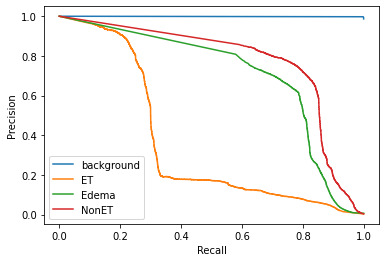

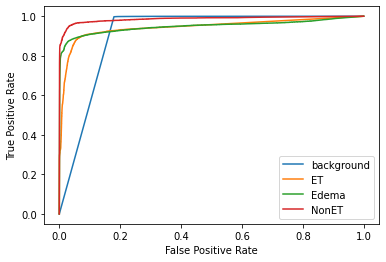

In [7]:
batch_plt_nb = 5
auc = np.zeros(4)
auccnt = np.zeros(4)
fig1 = plt.figure()
ax1 = plt.axes()
fig2 = plt.figure()
ax2 = plt.axes()
for i in range(358):
    # for some reason 210 predSoft won't load, maybe corrupted
    if i == 210:
        continue
    #print('Working on test slice ' + str(i))
    # loads the data
    p = Path(root_dir)
    files = []
    files.append(list(p.glob('predSoft'+str(i)+'.npz')))
    files.append(list(p.glob('y'+str(i)+'.npz')))
    predSoft = np.load(files[0][0])
    predSoft = predSoft['arr_0']
    y = np.load(files[1][0])
    y = y['arr_0']
    y = np.concatenate((np.sum(y,axis=-1,keepdims=True)==0,y),3)
    y = y.transpose((0,3,1,2))
    for j in range(y.shape[1]):
        if np.count_nonzero(y[:,j,:,:].flatten()) != 0:
            auc[j] += roc_auc_score(y[:,j,:,:].flatten(),predSoft[:,j,:,:].flatten())
            auccnt[j] += 1
    if i == int(batch_plt_nb):
        print('plotted ' + str(i))
        for j in range(y.shape[1]):
            precision, recall, _ = precision_recall_curve(y[:,j,:,:].flatten(),
                                                          predSoft[:,j,:,:].flatten())
            ax1.plot(recall,precision)
        ax1.legend(('background','ET','Edema','NonET'))
        ax1.set_ylabel('Precision')
        ax1.set_xlabel('Recall')
        for j in range(y.shape[1]):
            fpr, tpr, _ = roc_curve(y[:,j,:,:].flatten(),
                                    predSoft[:,j,:,:].flatten())
            ax2.plot(fpr,tpr)
        ax2.legend(('background','ET','Edema','NonET'))
        ax2.set_ylabel('True Positive Rate')
        ax2.set_xlabel('False Positive Rate')
auc /= auccnt
print(auc)